In [1]:
import pandas as pd
import json
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

In [2]:
def load_merge_data(gold_dir, gold_file, output_dir, output_file, valid_emotions):
    
    gold_labels_df = pd.read_csv(os.path.join(gold_dir, gold_file), sep='\t')
    gold_labels_df = gold_labels_df[gold_labels_df['Prior_Emotion'].str.lower().isin(valid_emotions)]
    gold_labels_df['Prior_Emotion'] = gold_labels_df['Prior_Emotion'].str.lower()

    with open(os.path.join(output_dir, output_file)) as file:
        data = json.load(file)

    parsed_data = {}
    for key, value in data.items():
        try:
            entry = json.loads(value)
            emotion_lower = entry['emotion'].lower()
            if emotion_lower in valid_emotions and entry['explanation'] not in parsed_data:
                parsed_data[entry['explanation']] = {
                    'Sentence_id': int(key),
                    'emotion': emotion_lower
                }
        except json.JSONDecodeError:
            continue

    persona_df = pd.DataFrame.from_dict(parsed_data, orient='index').reset_index(drop=True)
    return pd.merge(gold_labels_df, persona_df, on='Sentence_id')

In [3]:
def calculate_metrics(merged_df, valid_emotions):
    metrics = precision_recall_fscore_support(
        merged_df['Prior_Emotion'], merged_df['emotion'],
        average=None,
        labels=valid_emotions,
        zero_division=0
    )
    return pd.DataFrame({
        'Emotion': valid_emotions,
        'Precision': metrics[0],
        'Recall': metrics[1],
        'F1 Score': metrics[2]
    })

In [4]:
def plot_confusion_matrix(merged_df, valid_emotions, gender, save_dir, colour):
    cm = confusion_matrix(merged_df['Prior_Emotion'], merged_df['emotion'], labels=valid_emotions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_emotions)
    disp.plot(cmap=colour)
    plt.title(gender)
    plt.savefig(os.path.join(save_dir, f'{gender}_confusion_matrix.png'))
    plt.show()

In [5]:
gold_dir = '../dataset/deISEARenISEAR/'
gold_file = 'de2enISEAR.tsv'
output_dir = '../output/Meta-Llama-3-8B-Instruct/'
output_female = 'english_recall_female_1_results.json'
output_male = 'english_recall_male_1_results.json'

save_dir = '../output/conf_matrix_images/'
os.makedirs(save_dir, exist_ok=True)

valid_emotions = ["anger", "disgust", "fear", "joy", "sadness", "shame", "guilt"]

In [6]:
male_merged_df = load_merge_data(gold_dir, gold_file, output_dir, output_male, valid_emotions)
male_metrics = calculate_metrics(male_merged_df, valid_emotions)
print("Male Metrics:\n", male_metrics)

Male Metrics:
    Emotion  Precision    Recall  F1 Score
0    anger   0.602740  0.671756  0.635379
1  disgust   0.670886  0.768116  0.716216
2     fear   0.712329  0.753623  0.732394
3      joy   0.870748  0.934307  0.901408
4  sadness   0.730159  0.696970  0.713178
5    shame   0.905660  0.366412  0.521739
6    guilt   0.592593  0.732824  0.655290


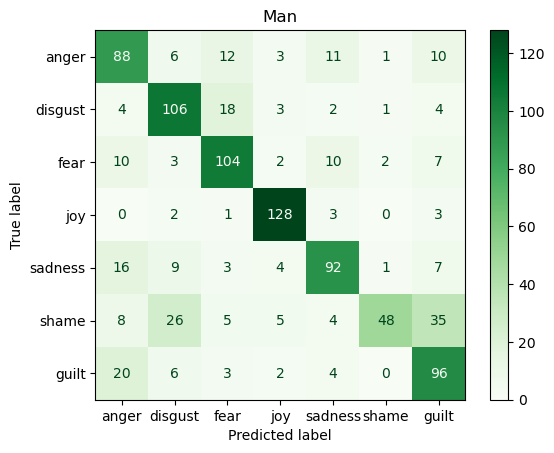

In [7]:
plot_confusion_matrix(male_merged_df, valid_emotions, 'Man', save_dir, plt.cm.Greens)

In [8]:
female_merged_df = load_merge_data(gold_dir, gold_file, output_dir, output_female, valid_emotions)
female_metrics = calculate_metrics(female_merged_df, valid_emotions)
print("Female Metrics:\n", female_metrics)

Female Metrics:
    Emotion  Precision    Recall  F1 Score
0    anger   0.843137  0.323308  0.467391
1  disgust   0.639053  0.782609  0.703583
2     fear   0.681818  0.772059  0.724138
3      joy   0.901408  0.907801  0.904594
4  sadness   0.518018  0.845588  0.642458
5    shame   0.897959  0.323529  0.475676
6    guilt   0.638554  0.796992  0.709030


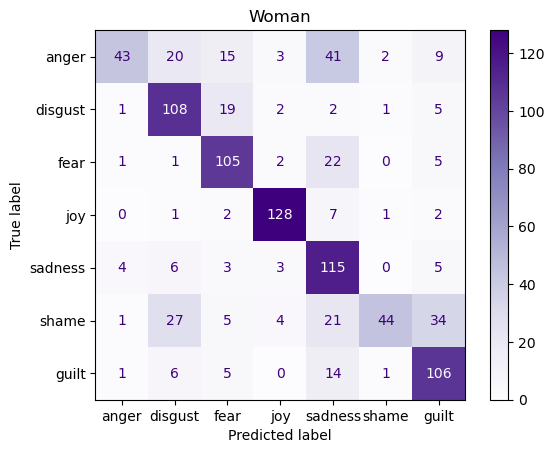

In [9]:
plot_confusion_matrix(female_merged_df, valid_emotions, 'Woman', save_dir, plt.cm.Purples)